In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from keras.applications.vgg19 import preprocess_input
import keras
from keras.preprocessing import image
from keras import Model
import keras.backend as K
from datetime import datetime
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay


*   Cilj ovog rada je transformacija fotografije u *nacrtanu* sliku. 
Ideja je da sadrzaj fotografije ostane nepromenjen, dok se stil fotografije menja u zavisnosti od zeljenog efekta. 
Ovaj efekat se postize primenom uzorka neke druge slike i *lepljenjem* za pocetnu.
Medjutim, nije moguce jednostavno lepljenje slika. Konacna slika se dobija postepenom/slojevitom primenom stila slike nad 
pocetnom slikom, racunajuci pritom slicnost dobijene slike sa pocetnom slikom i slikom sa stilom.
Ti slojevi koji se izdvajaju se dobijaju treba da na najbolji nacin opisu sadrzaj pocetne slike i stil slike sa kojom se mesa.
Tehnika kojom se postize ovaj efekat je neural style transfer. Ova tehnika koristi neuronske mreze kako bi mogao da dobije informacije
o slikama i koji slojevi cuvaju sadrzaj i stil.
Konvolutivne neuronske mreze koje su vec trenirane za klasifikaciju
slika, znaju kako i u kojoj meri treba da pronadju informacije  o sadrzaju i slici.
*   Purpose of this experiment is cartoonifying a picture using neural network. The idea is based on style transfer from picture A to picture B, perserving style and textures from picture A and content of  picture B. Because of their complex and human like structure, convolutional neural network are used to extract informations from pictures. Combination picture is produced by adding layer upon layer of style onto content picture. 





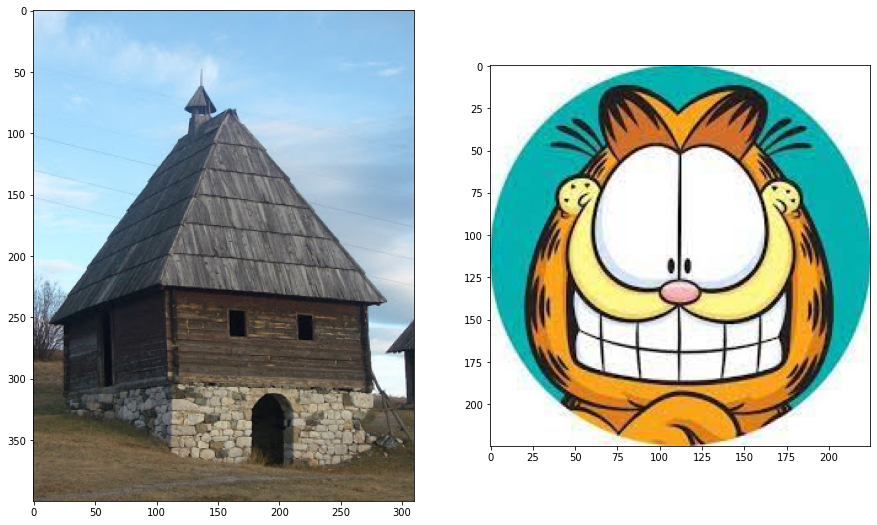

In [2]:
style_transfer_name = "garfield"
base_name = "house"

style_image_path ="drive/MyDrive/garfield.jpeg"
base_image_path = "drive/MyDrive/house.jpg"

# preview
bi = plt.imread(base_image_path)
si = plt.imread(style_image_path)
f, axarr = plt.subplots(1,2, figsize=(15,15))
axarr[0].imshow(bi)
axarr[1].imshow(si)
plt.show()

*  Pretrenirani model vgg za treniranje je koristio podatke iz ImageNet (projekat koji je napraveljen sa svrhom istrazivanja softvera za prepoznavanje objekata).
To je konvolutivna mreža koja kao ulaz prihvata sliku u boji, dimenzija 224x224. Slika prolazi kroz nekoliko konvolutivnih i agregacionih slojeva.
Konvolutivni sloj je karakteristican po tome sto koristi filtere, matrice relativno malih dimenzija . Filteri 
koji se koriste u konvolutivnim slojevima su dimenzija 3x3x3 (poslednja brojka odgovara broju kanala). 
Ono sto se uci kod konvolutivnog sloja su tezine koje odgovaraju skupu filtera.
Agregacioni slojevi imaju zadatak da smanje mogucnost preprilagodjavanja i smanje broj racunskih operacija. Njihovim koriscenjeem
ukrupnjuju se informacije iz prethodnog sloja primenom maksimizacije ili uprosecavanja. U slucaju ove mreze vrsi se maksimizacija sa matricom 2x2 sa korakom 2.
Takođe sadrzi 3 potpuno povezana sloja koja redom koriste relu i poslednji koristi softmax funkciju.
Za metodu style transfer se izdvajaju 5 grupa konvolutivnih slojeva, sa razlicitim brojem slojeva i međusobno razdvojeni agragacionim slojevima. Prva i druga grupa sadrže po 2 konvolutivna sloja,
treca, cetvrta i peta grupa sadrze po 4 konvolutivna sloja. 
Ovakva kompleksna struktura omogucuje da se prilikom treniranja mreze nauce razliciti aspekti neke slike. Prilikom treniranja ulazna slika se transformise u format koji sve vise
istice pravi sadrzaj te slike. Idejno sadrzaj koji ljudsko oko uocava je kontura odnosno prikaz nekog objekata na slici (jasan prikaz lopte ili osobe na slici), ali ovaj nivo sadrzaja se dobija u visim s
slojevima mreze. Kako bi se dobila informacija o formatu stila koriste se poseban prostor atributa koje je prvobitno razvijeno za izdvajanje teksture slike. Ovaj prostor je napravljen u svakom sloju mreze i sadrzi
korelacije izmedju razlicitih filtera, cime se dobija opste informacije o slici odnosno opsti izgled slike po pitanju boja i nekih lokalizovanih struktura.
Kombinovana slika se pravi tako sto se pronadje ona slika koja istovremeno sadrzi format prvobitne slike i stil zeljene slike sa stilom.

*   For this experiment we are using vgg pretrained model for image classification. Vgg was trained with ImageNet dataset. Input for this model iz an image (224x224). Vgg has several convolutional and pooling layers.  Convolutional layer is an application of filter to an input image, this application of the same filter results in a map of actiovations called a feature map. Cnn can learn a large number of filters.
Pooling layers are used to reduce of the feature maps and computational cost.
The idea of neural style transfer is to use pretrained weights and filters to extract important informations from images. From content image, we need defined object appearing on combination image. This information is stored in higher layers of neural network, so we need to choose one of the upper layers to define content of the image. Unlike content, style isn't defined by one particular layer. Every layer defines a specific texture and shapes from image, combining multiple layers we form unique texture that will define style from style image.



In [3]:
#dohvatanje vgg modela sa keras bibliotekom. Koriste se one tezine nadjene treniranjem sa imagenet-om ali bez dodatnih labela i klasa

model = vgg19.VGG19(weights="imagenet", include_top=False)

model.summary()

80150528/80134624 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________





*  Svaki sloj, pa i svaka grupa, ima zaduzenje da iz piksela izdvoji sto vise mogucih bitnih informacija. Tako ce neki sloj da nalazi 
ivice, neki drugi sloj ce da nalazi konture, neki treci sloj objekte i na osnovu svih tih saznanja vrsi se predvidjanje klase.
 
*   Every layer defines the set of pixels that encapsulate informations about contures, objects or shapes of an image


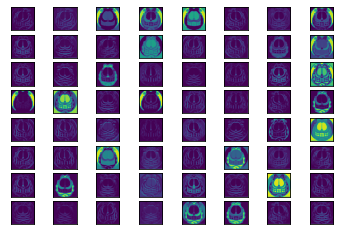

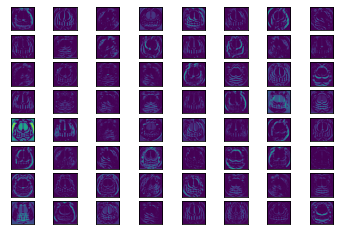

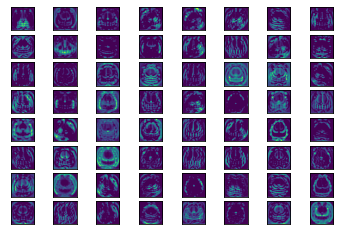

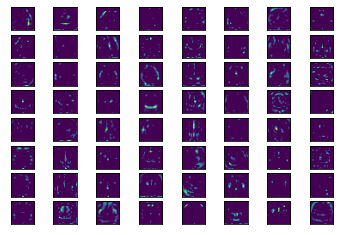

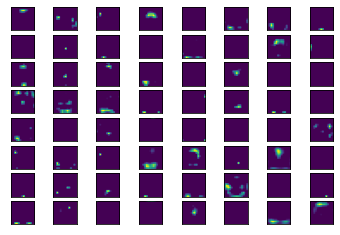

In [4]:

ixs = [2, 5, 10, 15, 20]
outputs = [model.layers[i].output for i in ixs]
model_visualize = Model(inputs=model.inputs, outputs=outputs)

img = image.load_img(style_image_path, target_size=(224, 224))

img = image.img_to_array(img)

img = np.expand_dims(img, axis=0)

img = preprocess_input(img)

feature_maps = model_visualize.predict(img)

square = 8
for fmap in feature_maps:

	ix = 1
	for _ in range(square):
		for _ in range(square):

			ax = plt.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])

			plt.imshow(fmap[0, :, :, ix-1])
			ix += 1

	plt.show()

* koriste se slojevi koje model sadrzi jer ce oni da se iskoriste za izdvajanje odredjenih karakteristika slika i njihovo kombinovanje.
* all layers of vgg model are used to extract style and content from images

In [5]:

outputs_dict= dict([(layer.name, layer.output) for layer in model.layers])

feature_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

* Svaki sloj definiše filter koji se primenjuje nad podacima. Svaki novi ulaz se enkodira filterima koje je CNN naučio. Svaki sloj može da ima $N_l$ filtera sa dimenzijama $M_l$ ($w\times h$).
Rezultat primene filtera je $F^l$ je matrica gde je $F^l_{ij}$ aktivacija i-tog filtera na poziciji j u sloju l. Ukoliko postoje dve slike koje predstavljaju originalnu sliku i kombinaciju te slike i stila ($P^l$ i $F^l$ su njihove reprezentacije) greska se definise formulom $L_{content}(comb, base) = \frac{1}{2}\sum_{i,j}(F_{ij}^l-P_{ij}^l)$

* To calculate the loss of content in the new combination image, we can use simple fomula $L_{content}(comb, base) = \frac{1}{2}\sum_{i,j}(F_{ij}^l-P_{ij}^l)$ where $P^l$ and $F^l$ are filter activation on two images (content image and combination image)


In [6]:
def loss_base_function(base, combination):
    return 0.5*K.sum(K.square(combination - base))

* Stil se drugacije racuna od sadrzaja. U ovom slucaju koristi se nekoliko slojeva kako bi se izvukao stil i zeljena tekstura. Dodatno koristi se korelacija izmedju razlicitih filtera u jednom sloju. Ova korelacija se izrazava Gramovom matricom $G_{ij}^l=\sum_k F^l_{ik}F_{jk}^l$
Kako bi se izracunala greska koja nastaje posle primene stila koristi se formula
$L_{style}(comb, style) = \sum_{l=0}^Lw_lE_l$
gde je $E_l = \frac{1}{4*N^2_lM^2_l}\sum_{i,j}(Gs_{i,j}^l - Gc_{i,j}^l)^2$

* To calculate style loss function we use gram matrix. In terms of style, multiple hidden layers are being used to create a sense of texture in combination image. Formula for gram matrix is $G_{ij}^l=\sum_k F^l_{ik}F_{jk}^l$ and it defines corelation between different filter on the same layer. 
Loss function is then calculated as $L_{style}(comb, style) = \sum_{l=0}^Lw_lE_l$
where $E_l = \frac{1}{4*N^2_lM^2_l}\sum_{i,j}(Gs_{i,j}^l - Gc_{i,j}^l)^2$


In [7]:
def gram_matrix(x):
    x = K.permute_dimensions(x, (2, 0, 1))
    x = K.batch_flatten(x)
    gram = K.dot(x, K.transpose(x))
    return gram

def loss_style_function(style, combination, size):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

* U ovom odeljku se izdvajaju oni slojevi koji ce se koristiti za izdvajanje stila slike (style) i sadrzaja (base - content). 
Neural style transfer se  moze smatrati jednom optimizacionom tehnikom koja minimizuje funkciju greske. Funkcija greske se rasclanjuje na gresku stila i gresku sadrzaja (style loss i content loss). Vaznost ovih gresaka se kontrolisu statickim tezinama, ukoliko zelimo da se istakne stil, tezina stila ce biti veca u odnosu na tezinu sadrzaja.
Za potrebe ovog rada koristi se stohasticni gradijentni spust.
* In this code bar we are extracting layers that will define content and style of new combination image. This is optimization problem so we are using stochastic gradient descent from keras library. Loss function, that is needed for optimization, is split into content loss function and style loss function because new combination image has to be mix of both images yet similar to both of them. To control the influence of style and content loss static weights are introduced. 

In [8]:
feature_space_style = [
    #"block1_conv1",
    "block1_conv2",
   #"block2_conv1",
    "block2_conv2",
   # "block3_conv1",
    "block3_conv3",
    #"block4_conv1",
    "block4_conv2",
    #"block5_conv1",
    "block5_conv4",
]

feature_content = "block3_conv1"

#dodaju se tezine koje su staticne i ukazuju na uticaj stila i sadrzaja. Tezina stila je jaca od tezine sadrzaja
content_weight = 2.8e-8
style_weight = 1e-6

def loss_function(combination_image, base_image, style_image, size):


    input_tensor = K.concatenate([base_image, style_image, combination_image], axis=0)


    features = feature_extractor(input_tensor)


    
    loss = tf.zeros(shape=())


    layer_features = features[feature_content]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]

    loss = loss + content_weight * loss_base_function(
        base_image_features, combination_features
    )

    for layer_name in feature_space_style:
        layer_features = features[layer_name]
        style_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = loss_style_function(style_features, combination_features, size)
        loss += (style_weight / len(feature_space_style)) * sl

    return loss

Za optimizaciju koristi se stohasticni gradijentni spust. Za brze racunanje koriste se povoljnosti tensorflow biblioteke.



In [10]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_image, size):
    with tf.GradientTape() as tape:
        loss = loss_function(combination_image, base_image, style_image, size)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [12]:

def preprocess_image(image_path, img_nrows, img_ncols):
    
    img = image.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = image.img_to_array(img, dtype='float32')
    img = np.expand_dims(img, axis=0)
    #img = img[:, :, :, :3]
    #img[:, :, :, 0] -= 103.939
    #img[:, :, :, 1] -= 116.779
    #img[:, :, :, 2] -= 123.68
    
    img = img[:, :, :, ::-1]

    return tf.convert_to_tensor(img)

In [13]:
def deprocess_image(img, img_nrows, img_ncols):

    img = img.reshape((img_nrows, img_ncols, 3))

   # x[:, :, 0] += 103.939
    #x[:, :, 1] += 116.779
   # x[:, :, 2] += 123.68

    img = img[:, :, ::-1]

    img = np.clip(img, 0, 255).astype("uint8")

    return img

In [14]:

def result_saver(iteration, combination_image, img_nrows, img_ncols):

    now = datetime.now()
    now = now.strftime("%Y%m%d_%H%M%S")

    image_name = 'a_'+style_transfer_name+"_"+base_name+"_"+str(iteration) + '_' + str(now)+"_image" + '.jpg'


    img = deprocess_image(combination_image.numpy(), img_nrows, img_ncols)
    keras.preprocessing.image.save_img(image_name, img)

In [15]:

#width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = 400#int(width * img_nrows / height)

optimizer = SGD(ExponentialDecay(initial_learning_rate=100.0, decay_steps=150, decay_rate=0.95))

base_image = preprocess_image(base_image_path, img_nrows, img_ncols)
style_image = preprocess_image(style_image_path, img_nrows, img_ncols)
combination_image = K.variable(preprocess_image(base_image_path, img_nrows, img_ncols))

iterations = 5000
losses = []
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_image, img_nrows*img_ncols)
    losses.append(loss)
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 500 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        result_saver(i, combination_image, img_nrows, img_ncols)

Iteration 500: loss=8936.90
Iteration 1000: loss=6287.62
Iteration 1500: loss=5561.79
Iteration 2000: loss=5288.88
Iteration 2500: loss=5141.01
Iteration 3000: loss=5046.61
Iteration 3500: loss=4980.66
Iteration 4000: loss=4932.40
Iteration 4500: loss=4895.09
Iteration 5000: loss=4867.17


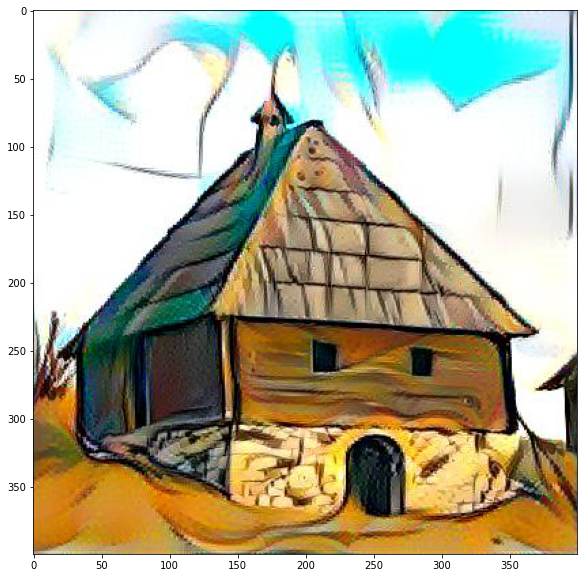

In [28]:

image_5000 =  plt.imread("/content/a_garfield_house_5000_20210831_172219_image.jpg", )
plt.figure(figsize=(10,10))
plt.imshow(image_5000)
plt.show()